## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)
        
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys
import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [28]:
reactomeVersion = 81
species = 48892
# species = 

endpointURL = "http://localhost:3030/REACTOME_MMUSCULUS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,114784
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,43809
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,27346
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,24826
4,http://www.biopax.org/release/biopax-level3.owl#Protein,23196
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,20362
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,20362
7,http://www.biopax.org/release/biopax-level3.owl#Complex,10707
8,http://www.biopax.org/release/biopax-level3.owl#Evidence,9904
9,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,9877


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

#### Summary <a class="anchor" id="summary"></a>
- complexes: 14840
- black box complexes: 858
- complexes that have at least one component: 13982
    - (complexes that are not black box complexes)
    - control: 14840-858=13982
    - they have up to 65 direct components
- complexes that have at least one component that is a complex: 6249
    - might be ok if all these components are black box complexes
    - 44.7% of 13982 
    - 42.1% of 14776 
    - control: complexes that have at least one component, none of which is a complex: 7733 (13982-6249=7733)
- complexes that have at least one component that is a black box complex: ~739~ 737
    - 11.8% of 6249 
- complexes that have at least one component that is a complex, and all its components that are complexes are actually black box complexes: ~517~ 515 
    - was expecting more, ideally 6249 
    - 8.2% of 6249 
- complexes that have at least one component that is a complex but not a black box complex: ~5710~ 5734
    - **these complexes should be fixed**
    - 38.6% of 14840
    - 41% of 13982
- complexes that are not black boxes but are a component of at least another complex: 4333
    - **they are the ones to look at for fixing the 5734**
    - they can be valid (i.e. all their components that are complexes are black box complexes) or invalid
    - they can be involved in chemical reactions (and therefore we should keep them, possibly after making them compliant and after detecting redundancies) or not (and these we can probably discard)
    -  ~1032~  of them are the direct component of more than one complex (max = direct component of 65 complexes)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,570


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,10137


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4528


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,5609


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,454


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,293


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4235


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3478


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    10707.000000
mean         2.314187
std          2.862322
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

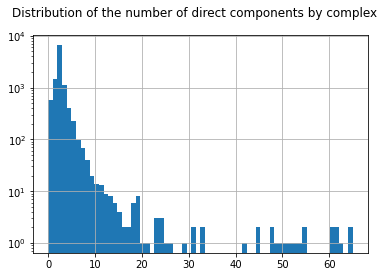

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

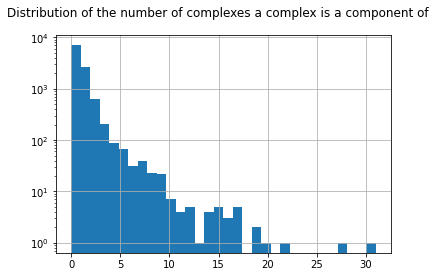

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,14725


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,6261


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,5481


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,8138


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,8691


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 # ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2
0,http://www.reactome.org/biopax/81/48892#Complex4303,http://www.reactome.org/biopax/81/48892#Complex5127
1,http://www.reactome.org/biopax/81/48892#Complex5014,http://www.reactome.org/biopax/81/48892#Complex9983


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

2

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [32]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w') as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))
        i += 1
    
    # ${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [33]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode('UTF-8').decode('UTF-8'))

Function 3: delete all complexes

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [29]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.222733736038208	http://www.reactome.org/biopax/81/48892#Complex2
1	0.41260433197021484	http://www.reactome.org/biopax/81/48892#Complex5
2	0.5607423782348633	http://www.reactome.org/biopax/81/48892#Complex6
3	0.7854487895965576	http://www.reactome.org/biopax/81/48892#Complex8
4	1.1270081996917725	http://www.reactome.org/biopax/81/48892#Complex14
5	1.2792296409606934	http://www.reactome.org/biopax/81/48892#Complex15
6	1.457664966583252	http://www.reactome.org/biopax/81/48892#Complex17
7	1.7149574756622314	http://www.reactome.org/biopax/81/48892#Complex18
8	1.883601427078247	http://www.reactome.org/biopax/81/48892#Complex21
9	2.077937126159668	http://www.reactome.org/biopax/81/48892#Complex19
10	2.169667959213257	http://www.reactome.org/biopax/81/48892#Complex22
11	2.381594181060791	http://www.reactome.org/biopax/81/48892#Complex26
12	2.7537167072296143	http://www.reactome.org/biopax/81/48892#Complex23
13	2.9176478385925293	http://www.reactome.org/biopax/81/48892#Complex27
14	3.195429

115	27.6511390209198	http://www.reactome.org/biopax/81/48892#Complex271
116	27.747660875320435	http://www.reactome.org/biopax/81/48892#Complex274
117	27.868894338607788	http://www.reactome.org/biopax/81/48892#Complex276
118	27.97555923461914	http://www.reactome.org/biopax/81/48892#Complex285
119	28.080989122390747	http://www.reactome.org/biopax/81/48892#Complex288
120	28.160562753677368	http://www.reactome.org/biopax/81/48892#Complex290
121	28.276997327804565	http://www.reactome.org/biopax/81/48892#Complex291
122	28.770697355270386	http://www.reactome.org/biopax/81/48892#Complex295
123	30.304150581359863	http://www.reactome.org/biopax/81/48892#Complex296
124	30.407450199127197	http://www.reactome.org/biopax/81/48892#Complex299
125	30.607908248901367	http://www.reactome.org/biopax/81/48892#Complex300
126	31.41378402709961	http://www.reactome.org/biopax/81/48892#Complex306
127	31.50832438468933	http://www.reactome.org/biopax/81/48892#Complex309
128	32.14655113220215	http://www.reactome.o

227	84.55097436904907	http://www.reactome.org/biopax/81/48892#Complex577
228	85.0030083656311	http://www.reactome.org/biopax/81/48892#Complex579
229	85.57940888404846	http://www.reactome.org/biopax/81/48892#Complex580
230	85.8588457107544	http://www.reactome.org/biopax/81/48892#Complex582
231	86.31046271324158	http://www.reactome.org/biopax/81/48892#Complex583
232	86.82771873474121	http://www.reactome.org/biopax/81/48892#Complex584
233	87.37622094154358	http://www.reactome.org/biopax/81/48892#Complex585
234	88.14107084274292	http://www.reactome.org/biopax/81/48892#Complex586
235	88.9328601360321	http://www.reactome.org/biopax/81/48892#Complex587
236	89.50775527954102	http://www.reactome.org/biopax/81/48892#Complex588
237	89.98984336853027	http://www.reactome.org/biopax/81/48892#Complex592
238	90.23427844047546	http://www.reactome.org/biopax/81/48892#Complex595
239	90.4913694858551	http://www.reactome.org/biopax/81/48892#Complex593
240	90.6983892917633	http://www.reactome.org/biopax/81/

339	291.15302896499634	http://www.reactome.org/biopax/81/48892#Complex814
340	291.92165350914	http://www.reactome.org/biopax/81/48892#Complex815
341	292.1099433898926	http://www.reactome.org/biopax/81/48892#Complex817
342	293.2810769081116	http://www.reactome.org/biopax/81/48892#Complex819
343	294.57785153388977	http://www.reactome.org/biopax/81/48892#Complex822
344	295.7682292461395	http://www.reactome.org/biopax/81/48892#Complex824
345	295.9754099845886	http://www.reactome.org/biopax/81/48892#Complex828
346	296.2084288597107	http://www.reactome.org/biopax/81/48892#Complex825
347	296.41458916664124	http://www.reactome.org/biopax/81/48892#Complex829
348	296.6114459037781	http://www.reactome.org/biopax/81/48892#Complex833
349	297.27340817451477	http://www.reactome.org/biopax/81/48892#Complex834
350	297.89424228668213	http://www.reactome.org/biopax/81/48892#Complex835
351	298.45675587654114	http://www.reactome.org/biopax/81/48892#Complex836
352	298.96338057518005	http://www.reactome.org/

452	356.2600996494293	http://www.reactome.org/biopax/81/48892#Complex1162
453	356.3770637512207	http://www.reactome.org/biopax/81/48892#Complex1165
454	356.5270640850067	http://www.reactome.org/biopax/81/48892#Complex1167
455	356.6100640296936	http://www.reactome.org/biopax/81/48892#Complex1184
456	356.72519087791443	http://www.reactome.org/biopax/81/48892#Complex1185
457	356.9000823497772	http://www.reactome.org/biopax/81/48892#Complex1189
458	357.140172958374	http://www.reactome.org/biopax/81/48892#Complex1187
459	357.2517695426941	http://www.reactome.org/biopax/81/48892#Complex1190
460	357.3654203414917	http://www.reactome.org/biopax/81/48892#Complex1191
461	357.59781765937805	http://www.reactome.org/biopax/81/48892#Complex1193
462	357.90260124206543	http://www.reactome.org/biopax/81/48892#Complex1194
463	358.00976610183716	http://www.reactome.org/biopax/81/48892#Complex1195
464	358.2067663669586	http://www.reactome.org/biopax/81/48892#Complex1196
465	358.39783811569214	http://www.r

563	377.46067667007446	http://www.reactome.org/biopax/81/48892#Complex1449
564	377.66776871681213	http://www.reactome.org/biopax/81/48892#Complex1451
565	377.76808500289917	http://www.reactome.org/biopax/81/48892#Complex1452
566	377.8539488315582	http://www.reactome.org/biopax/81/48892#Complex1454
567	377.94417548179626	http://www.reactome.org/biopax/81/48892#Complex1455
568	378.06715202331543	http://www.reactome.org/biopax/81/48892#Complex1457
569	378.22431445121765	http://www.reactome.org/biopax/81/48892#Complex1459
570	378.41031551361084	http://www.reactome.org/biopax/81/48892#Complex1460
571	378.5004782676697	http://www.reactome.org/biopax/81/48892#Complex1465
572	378.6396768093109	http://www.reactome.org/biopax/81/48892#Complex1466
573	378.8136773109436	http://www.reactome.org/biopax/81/48892#Complex1468
574	378.9239971637726	http://www.reactome.org/biopax/81/48892#Complex1470
575	379.01099944114685	http://www.reactome.org/biopax/81/48892#Complex1471
576	379.12207555770874	http://

674	390.5274920463562	http://www.reactome.org/biopax/81/48892#Complex1860
675	390.61449217796326	http://www.reactome.org/biopax/81/48892#Complex1872
676	390.67552614212036	http://www.reactome.org/biopax/81/48892#Complex1874
677	390.77152037620544	http://www.reactome.org/biopax/81/48892#Complex1881
678	390.88553047180176	http://www.reactome.org/biopax/81/48892#Complex1882
679	391.0004165172577	http://www.reactome.org/biopax/81/48892#Complex1883
680	391.0884201526642	http://www.reactome.org/biopax/81/48892#Complex1884
681	391.18379855155945	http://www.reactome.org/biopax/81/48892#Complex1885
682	391.27042746543884	http://www.reactome.org/biopax/81/48892#Complex1886
683	391.4143099784851	http://www.reactome.org/biopax/81/48892#Complex1887
684	391.49638175964355	http://www.reactome.org/biopax/81/48892#Complex1893
685	391.5834140777588	http://www.reactome.org/biopax/81/48892#Complex1895
686	391.64154601097107	http://www.reactome.org/biopax/81/48892#Complex1901
687	391.72342705726624	http://

786	409.0285716056824	http://www.reactome.org/biopax/81/48892#Complex2136
787	409.1157035827637	http://www.reactome.org/biopax/81/48892#Complex2137
788	409.232923746109	http://www.reactome.org/biopax/81/48892#Complex2138
789	409.4169268608093	http://www.reactome.org/biopax/81/48892#Complex2145
790	409.7053072452545	http://www.reactome.org/biopax/81/48892#Complex2139
791	409.76436948776245	http://www.reactome.org/biopax/81/48892#Complex2146
792	409.96564960479736	http://www.reactome.org/biopax/81/48892#Complex2147
793	410.0765883922577	http://www.reactome.org/biopax/81/48892#Complex2149
794	410.38475728034973	http://www.reactome.org/biopax/81/48892#Complex2150
795	410.50390791893005	http://www.reactome.org/biopax/81/48892#Complex2151
796	410.8168511390686	http://www.reactome.org/biopax/81/48892#Complex2152
797	410.8788855075836	http://www.reactome.org/biopax/81/48892#Complex2154
798	411.22785329818726	http://www.reactome.org/biopax/81/48892#Complex2155
799	411.28777265548706	http://www.

899	425.81796884536743	http://www.reactome.org/biopax/81/48892#Complex2402
900	425.93596863746643	http://www.reactome.org/biopax/81/48892#Complex2404
901	426.09022092819214	http://www.reactome.org/biopax/81/48892#Complex2405
902	426.2399551868439	http://www.reactome.org/biopax/81/48892#Complex2406
903	426.3944914340973	http://www.reactome.org/biopax/81/48892#Complex2407
904	426.4842755794525	http://www.reactome.org/biopax/81/48892#Complex2408
905	426.64474725723267	http://www.reactome.org/biopax/81/48892#Complex2409
906	426.8009629249573	http://www.reactome.org/biopax/81/48892#Complex2410
907	426.8899621963501	http://www.reactome.org/biopax/81/48892#Complex2412
908	427.00396394729614	http://www.reactome.org/biopax/81/48892#Complex2415
909	427.2099726200104	http://www.reactome.org/biopax/81/48892#Complex2419
910	427.36211800575256	http://www.reactome.org/biopax/81/48892#Complex2416
911	427.50838565826416	http://www.reactome.org/biopax/81/48892#Complex2417
912	427.5945267677307	http://ww

1011	442.15144968032837	http://www.reactome.org/biopax/81/48892#Complex2614
1012	442.23920798301697	http://www.reactome.org/biopax/81/48892#Complex2615
1013	442.2969651222229	http://www.reactome.org/biopax/81/48892#Complex2616
1014	442.36454486846924	http://www.reactome.org/biopax/81/48892#Complex2619
1015	442.45437121391296	http://www.reactome.org/biopax/81/48892#Complex2621
1016	442.57182359695435	http://www.reactome.org/biopax/81/48892#Complex2623
1017	442.81992626190186	http://www.reactome.org/biopax/81/48892#Complex2624
1018	442.96599316596985	http://www.reactome.org/biopax/81/48892#Complex2625
1019	443.0857238769531	http://www.reactome.org/biopax/81/48892#Complex2626
1020	443.2000193595886	http://www.reactome.org/biopax/81/48892#Complex2629
1021	443.2880222797394	http://www.reactome.org/biopax/81/48892#Complex2630
1022	443.3485095500946	http://www.reactome.org/biopax/81/48892#Complex2631
1023	443.46319365501404	http://www.reactome.org/biopax/81/48892#Complex2632
1024	443.58345651

1121	454.4075677394867	http://www.reactome.org/biopax/81/48892#Complex2822
1122	454.6016569137573	http://www.reactome.org/biopax/81/48892#Complex2823
1123	454.7591869831085	http://www.reactome.org/biopax/81/48892#Complex2824
1124	454.94417667388916	http://www.reactome.org/biopax/81/48892#Complex2825
1125	455.092246055603	http://www.reactome.org/biopax/81/48892#Complex2826
1126	455.23675322532654	http://www.reactome.org/biopax/81/48892#Complex2828
1127	455.40153431892395	http://www.reactome.org/biopax/81/48892#Complex2830
1128	455.4902489185333	http://www.reactome.org/biopax/81/48892#Complex2831
1129	455.58624958992004	http://www.reactome.org/biopax/81/48892#Complex2832
1130	455.7183768749237	http://www.reactome.org/biopax/81/48892#Complex2834
1131	455.8702311515808	http://www.reactome.org/biopax/81/48892#Complex2836
1132	455.96030497550964	http://www.reactome.org/biopax/81/48892#Complex2837
1133	456.045047044754	http://www.reactome.org/biopax/81/48892#Complex2838
1134	456.1491138935089

1231	468.71647453308105	http://www.reactome.org/biopax/81/48892#Complex3284
1232	468.89946961402893	http://www.reactome.org/biopax/81/48892#Complex3285
1233	469.0794746875763	http://www.reactome.org/biopax/81/48892#Complex3286
1234	469.19946670532227	http://www.reactome.org/biopax/81/48892#Complex3288
1235	469.3214702606201	http://www.reactome.org/biopax/81/48892#Complex3289
1236	469.41552352905273	http://www.reactome.org/biopax/81/48892#Complex3296
1237	469.583660364151	http://www.reactome.org/biopax/81/48892#Complex3297
1238	469.74261355400085	http://www.reactome.org/biopax/81/48892#Complex3299
1239	469.82748889923096	http://www.reactome.org/biopax/81/48892#Complex3300
1240	469.9212636947632	http://www.reactome.org/biopax/81/48892#Complex3301
1241	470.03984093666077	http://www.reactome.org/biopax/81/48892#Complex3302
1242	470.12846326828003	http://www.reactome.org/biopax/81/48892#Complex3303
1243	470.21496200561523	http://www.reactome.org/biopax/81/48892#Complex3305
1244	470.33184337

1341	484.5244815349579	http://www.reactome.org/biopax/81/48892#Complex3563
1342	484.6796541213989	http://www.reactome.org/biopax/81/48892#Complex3566
1343	484.849650144577	http://www.reactome.org/biopax/81/48892#Complex3567
1344	485.0535852909088	http://www.reactome.org/biopax/81/48892#Complex3579
1345	485.1626522541046	http://www.reactome.org/biopax/81/48892#Complex3585
1346	485.25968766212463	http://www.reactome.org/biopax/81/48892#Complex3586
1347	485.3597357273102	http://www.reactome.org/biopax/81/48892#Complex3588
1348	485.4587359428406	http://www.reactome.org/biopax/81/48892#Complex3590
1349	485.5523307323456	http://www.reactome.org/biopax/81/48892#Complex3598
1350	485.6754276752472	http://www.reactome.org/biopax/81/48892#Complex3599
1351	485.78625226020813	http://www.reactome.org/biopax/81/48892#Complex3600
1352	485.86955976486206	http://www.reactome.org/biopax/81/48892#Complex3601
1353	485.95046210289	http://www.reactome.org/biopax/81/48892#Complex3616
1354	486.0335023403168	ht

1452	503.2325463294983	http://www.reactome.org/biopax/81/48892#Complex3802
1453	503.3245458602905	http://www.reactome.org/biopax/81/48892#Complex3803
1454	503.39679193496704	http://www.reactome.org/biopax/81/48892#Complex3804
1455	503.45775628089905	http://www.reactome.org/biopax/81/48892#Complex3805
1456	503.5730061531067	http://www.reactome.org/biopax/81/48892#Complex3807
1457	503.6311240196228	http://www.reactome.org/biopax/81/48892#Complex3808
1458	503.75111198425293	http://www.reactome.org/biopax/81/48892#Complex3810
1459	503.90308022499084	http://www.reactome.org/biopax/81/48892#Complex3811
1460	503.98597264289856	http://www.reactome.org/biopax/81/48892#Complex3814
1461	504.07501554489136	http://www.reactome.org/biopax/81/48892#Complex3815
1462	504.1609971523285	http://www.reactome.org/biopax/81/48892#Complex3816
1463	504.30898356437683	http://www.reactome.org/biopax/81/48892#Complex3817
1464	504.43598651885986	http://www.reactome.org/biopax/81/48892#Complex3819
1465	504.52641940

1563	518.5809061527252	http://www.reactome.org/biopax/81/48892#Complex4081
1564	518.7129120826721	http://www.reactome.org/biopax/81/48892#Complex4082
1565	518.9199888706207	http://www.reactome.org/biopax/81/48892#Complex4083
1566	518.9833619594574	http://www.reactome.org/biopax/81/48892#Complex4084
1567	519.1132671833038	http://www.reactome.org/biopax/81/48892#Complex4085
1568	519.1812698841095	http://www.reactome.org/biopax/81/48892#Complex4088
1569	519.3122673034668	http://www.reactome.org/biopax/81/48892#Complex4089
1570	519.3782811164856	http://www.reactome.org/biopax/81/48892#Complex4092
1571	519.5568859577179	http://www.reactome.org/biopax/81/48892#Complex4093
1572	519.7261555194855	http://www.reactome.org/biopax/81/48892#Complex4094
1573	520.0356526374817	http://www.reactome.org/biopax/81/48892#Complex4096
1574	520.3439321517944	http://www.reactome.org/biopax/81/48892#Complex4098
1575	520.7105286121368	http://www.reactome.org/biopax/81/48892#Complex4104
1576	521.0964283943176	ht

1674	552.221522808075	http://www.reactome.org/biopax/81/48892#Complex4288
1675	552.4049043655396	http://www.reactome.org/biopax/81/48892#Complex4289
1676	552.5988125801086	http://www.reactome.org/biopax/81/48892#Complex4290
1677	552.8048505783081	http://www.reactome.org/biopax/81/48892#Complex4291
1678	553.0654621124268	http://www.reactome.org/biopax/81/48892#Complex4293
1679	553.286981344223	http://www.reactome.org/biopax/81/48892#Complex4294
1680	553.5850193500519	http://www.reactome.org/biopax/81/48892#Complex4298
1681	553.9500226974487	http://www.reactome.org/biopax/81/48892#Complex4295
1682	554.1696631908417	http://www.reactome.org/biopax/81/48892#Complex4300
1683	554.5080215930939	http://www.reactome.org/biopax/81/48892#Complex4301
1684	554.8242774009705	http://www.reactome.org/biopax/81/48892#Complex4305
1685	554.9781346321106	http://www.reactome.org/biopax/81/48892#Complex4306
1686	555.0599596500397	http://www.reactome.org/biopax/81/48892#Complex4307
1687	555.1401431560516	http

1784	573.1267385482788	http://www.reactome.org/biopax/81/48892#Complex4653
1785	574.4090793132782	http://www.reactome.org/biopax/81/48892#Complex4657
1786	574.5180733203888	http://www.reactome.org/biopax/81/48892#Complex4658
1787	575.6981399059296	http://www.reactome.org/biopax/81/48892#Complex4662
1788	577.105170249939	http://www.reactome.org/biopax/81/48892#Complex4659
1789	577.6178605556488	http://www.reactome.org/biopax/81/48892#Complex4661
1790	577.9300754070282	http://www.reactome.org/biopax/81/48892#Complex4663
1791	579.2612690925598	http://www.reactome.org/biopax/81/48892#Complex4664
1792	580.7194757461548	http://www.reactome.org/biopax/81/48892#Complex4665
1793	581.9836895465851	http://www.reactome.org/biopax/81/48892#Complex4666
1794	583.3170087337494	http://www.reactome.org/biopax/81/48892#Complex4667
1795	584.6274261474609	http://www.reactome.org/biopax/81/48892#Complex4669
1796	585.1254348754883	http://www.reactome.org/biopax/81/48892#Complex4670
1797	585.8100788593292	htt

1894	832.138777256012	http://www.reactome.org/biopax/81/48892#Complex4857
1895	832.7239456176758	http://www.reactome.org/biopax/81/48892#Complex4859
1896	833.4560165405273	http://www.reactome.org/biopax/81/48892#Complex4860
1897	833.7707839012146	http://www.reactome.org/biopax/81/48892#Complex4863
1898	840.2432076931	http://www.reactome.org/biopax/81/48892#Complex4865
1899	840.3982455730438	http://www.reactome.org/biopax/81/48892#Complex4868
1900	840.4892418384552	http://www.reactome.org/biopax/81/48892#Complex4869
1901	840.5523238182068	http://www.reactome.org/biopax/81/48892#Complex4870
1902	840.6753733158112	http://www.reactome.org/biopax/81/48892#Complex4873
1903	840.8443324565887	http://www.reactome.org/biopax/81/48892#Complex4874
1904	841.3284080028534	http://www.reactome.org/biopax/81/48892#Complex4876
1905	842.772748708725	http://www.reactome.org/biopax/81/48892#Complex4878
1906	842.854630947113	http://www.reactome.org/biopax/81/48892#Complex4880
1907	842.9596309661865	http://w

2005	926.3972265720367	http://www.reactome.org/biopax/81/48892#Complex5138
2006	926.5683822631836	http://www.reactome.org/biopax/81/48892#Complex5139
2007	926.8502671718597	http://www.reactome.org/biopax/81/48892#Complex5140
2008	927.132541179657	http://www.reactome.org/biopax/81/48892#Complex5141
2009	927.2886006832123	http://www.reactome.org/biopax/81/48892#Complex5143
2010	927.4126386642456	http://www.reactome.org/biopax/81/48892#Complex5145
2011	927.5196375846863	http://www.reactome.org/biopax/81/48892#Complex5147
2012	927.6095993518829	http://www.reactome.org/biopax/81/48892#Complex5149
2013	927.701642036438	http://www.reactome.org/biopax/81/48892#Complex5152
2014	927.8246371746063	http://www.reactome.org/biopax/81/48892#Complex5154
2015	935.2279064655304	http://www.reactome.org/biopax/81/48892#Complex5155
2016	942.988320350647	http://www.reactome.org/biopax/81/48892#Complex5160
2017	943.1113257408142	http://www.reactome.org/biopax/81/48892#Complex5161
2018	943.1937177181244	http:

2115	967.5701196193695	http://www.reactome.org/biopax/81/48892#Complex5434
2116	967.6880717277527	http://www.reactome.org/biopax/81/48892#Complex5436
2117	968.1006305217743	http://www.reactome.org/biopax/81/48892#Complex5437
2118	968.2326695919037	http://www.reactome.org/biopax/81/48892#Complex5438
2119	968.7462470531464	http://www.reactome.org/biopax/81/48892#Complex5441
2120	969.4031918048859	http://www.reactome.org/biopax/81/48892#Complex5450
2121	969.5881979465485	http://www.reactome.org/biopax/81/48892#Complex5448
2122	969.699756860733	http://www.reactome.org/biopax/81/48892#Complex5453
2123	969.8027541637421	http://www.reactome.org/biopax/81/48892#Complex5454
2124	969.9767596721649	http://www.reactome.org/biopax/81/48892#Complex5460
2125	970.084760427475	http://www.reactome.org/biopax/81/48892#Complex5461
2126	970.7187292575836	http://www.reactome.org/biopax/81/48892#Complex5462
2127	971.5663487911224	http://www.reactome.org/biopax/81/48892#Complex5463
2128	971.6524391174316	http

2225	1008.8799047470093	http://www.reactome.org/biopax/81/48892#Complex5736
2226	1008.9573421478271	http://www.reactome.org/biopax/81/48892#Complex5745
2227	1009.0579648017883	http://www.reactome.org/biopax/81/48892#Complex5739
2228	1009.1648597717285	http://www.reactome.org/biopax/81/48892#Complex5742
2229	1009.317046880722	http://www.reactome.org/biopax/81/48892#Complex5743
2230	1009.4262020587921	http://www.reactome.org/biopax/81/48892#Complex5746
2231	1009.5630505084991	http://www.reactome.org/biopax/81/48892#Complex5747
2232	1009.6991827487946	http://www.reactome.org/biopax/81/48892#Complex5748
2233	1009.7945635318756	http://www.reactome.org/biopax/81/48892#Complex5756
2234	1009.8581719398499	http://www.reactome.org/biopax/81/48892#Complex5750
2235	1009.9557673931122	http://www.reactome.org/biopax/81/48892#Complex5753
2236	1010.093727350235	http://www.reactome.org/biopax/81/48892#Complex5754
2237	1010.1827280521393	http://www.reactome.org/biopax/81/48892#Complex5755
2238	1010.2667

2334	1040.318960905075	http://www.reactome.org/biopax/81/48892#Complex6038
2335	1040.834154844284	http://www.reactome.org/biopax/81/48892#Complex6039
2336	1041.495224237442	http://www.reactome.org/biopax/81/48892#Complex6040
2337	1042.138028383255	http://www.reactome.org/biopax/81/48892#Complex6041
2338	1042.7021243572235	http://www.reactome.org/biopax/81/48892#Complex6042
2339	1043.0153074264526	http://www.reactome.org/biopax/81/48892#Complex6043
2340	1043.3252248764038	http://www.reactome.org/biopax/81/48892#Complex6044
2341	1043.8139090538025	http://www.reactome.org/biopax/81/48892#Complex6045
2342	1044.2979128360748	http://www.reactome.org/biopax/81/48892#Complex6046
2343	1044.6108589172363	http://www.reactome.org/biopax/81/48892#Complex6047
2344	1044.9079411029816	http://www.reactome.org/biopax/81/48892#Complex6048
2345	1044.988941669464	http://www.reactome.org/biopax/81/48892#Complex6049
2346	1045.0729413032532	http://www.reactome.org/biopax/81/48892#Complex6050
2347	1045.1655333

2443	1137.7842049598694	http://www.reactome.org/biopax/81/48892#Complex6253
2444	1137.9829425811768	http://www.reactome.org/biopax/81/48892#Complex6260
2445	1138.1676349639893	http://www.reactome.org/biopax/81/48892#Complex6258
2446	1138.3155102729797	http://www.reactome.org/biopax/81/48892#Complex6255
2447	1138.4768340587616	http://www.reactome.org/biopax/81/48892#Complex6256
2448	1138.6077983379364	http://www.reactome.org/biopax/81/48892#Complex6257
2449	1138.7438352108002	http://www.reactome.org/biopax/81/48892#Complex6261
2450	1138.885647535324	http://www.reactome.org/biopax/81/48892#Complex6263
2451	1139.1539905071259	http://www.reactome.org/biopax/81/48892#Complex6264
2452	1139.4671788215637	http://www.reactome.org/biopax/81/48892#Complex6265
2453	1139.7742519378662	http://www.reactome.org/biopax/81/48892#Complex6266
2454	1140.0384809970856	http://www.reactome.org/biopax/81/48892#Complex6267
2455	1140.1860642433167	http://www.reactome.org/biopax/81/48892#Complex6270
2456	1141.341

2552	1176.220823764801	http://www.reactome.org/biopax/81/48892#Complex6456
2553	1176.8944149017334	http://www.reactome.org/biopax/81/48892#Complex6457
2554	1177.630532503128	http://www.reactome.org/biopax/81/48892#Complex6458
2555	1178.4044325351715	http://www.reactome.org/biopax/81/48892#Complex6459
2556	1179.1661422252655	http://www.reactome.org/biopax/81/48892#Complex6460
2557	1179.6146364212036	http://www.reactome.org/biopax/81/48892#Complex6461
2558	1180.3856055736542	http://www.reactome.org/biopax/81/48892#Complex6462
2559	1181.2636699676514	http://www.reactome.org/biopax/81/48892#Complex6466
2560	1181.3627791404724	http://www.reactome.org/biopax/81/48892#Complex6467
2561	1181.446700334549	http://www.reactome.org/biopax/81/48892#Complex6469
2562	1182.5545647144318	http://www.reactome.org/biopax/81/48892#Complex6471
2563	1183.6775617599487	http://www.reactome.org/biopax/81/48892#Complex6474
2564	1184.7659275531769	http://www.reactome.org/biopax/81/48892#Complex6475
2565	1185.66693

2661	1227.2147896289825	http://www.reactome.org/biopax/81/48892#Complex6609
2662	1228.1018688678741	http://www.reactome.org/biopax/81/48892#Complex6610
2663	1229.0603499412537	http://www.reactome.org/biopax/81/48892#Complex6611
2664	1229.9772670269012	http://www.reactome.org/biopax/81/48892#Complex6612
2665	1230.3351526260376	http://www.reactome.org/biopax/81/48892#Complex6614
2666	1231.5213537216187	http://www.reactome.org/biopax/81/48892#Complex6615
2667	1232.894297361374	http://www.reactome.org/biopax/81/48892#Complex6616
2668	1234.1606550216675	http://www.reactome.org/biopax/81/48892#Complex6618
2669	1235.2212159633636	http://www.reactome.org/biopax/81/48892#Complex6622
2670	1237.9340527057648	http://www.reactome.org/biopax/81/48892#Complex6623
2671	1240.5459163188934	http://www.reactome.org/biopax/81/48892#Complex6624
2672	1242.237104177475	http://www.reactome.org/biopax/81/48892#Complex6625
2673	1243.7292928695679	http://www.reactome.org/biopax/81/48892#Complex6626
2674	1246.0362

2770	1291.092229127884	http://www.reactome.org/biopax/81/48892#Complex6839
2771	1291.2043278217316	http://www.reactome.org/biopax/81/48892#Complex6840
2772	1291.321366071701	http://www.reactome.org/biopax/81/48892#Complex6842
2773	1291.396365404129	http://www.reactome.org/biopax/81/48892#Complex6843
2774	1291.477328300476	http://www.reactome.org/biopax/81/48892#Complex6844
2775	1291.5629110336304	http://www.reactome.org/biopax/81/48892#Complex6847
2776	1291.6392164230347	http://www.reactome.org/biopax/81/48892#Complex6849
2777	1291.7100183963776	http://www.reactome.org/biopax/81/48892#Complex6853
2778	1291.7779757976532	http://www.reactome.org/biopax/81/48892#Complex6858
2779	1291.8973479270935	http://www.reactome.org/biopax/81/48892#Complex6862
2780	1291.9910972118378	http://www.reactome.org/biopax/81/48892#Complex6863
2781	1292.0784430503845	http://www.reactome.org/biopax/81/48892#Complex6866
2782	1292.1970896720886	http://www.reactome.org/biopax/81/48892#Complex6867
2783	1292.289861

2879	1329.4001672267914	http://www.reactome.org/biopax/81/48892#Complex7453
2880	1330.379222869873	http://www.reactome.org/biopax/81/48892#Complex7454
2881	1331.1452231407166	http://www.reactome.org/biopax/81/48892#Complex7456
2882	1331.2076547145844	http://www.reactome.org/biopax/81/48892#Complex7457
2883	1331.2737863063812	http://www.reactome.org/biopax/81/48892#Complex7459
2884	1331.3649489879608	http://www.reactome.org/biopax/81/48892#Complex7465
2885	1331.4285259246826	http://www.reactome.org/biopax/81/48892#Complex7467
2886	1331.487524986267	http://www.reactome.org/biopax/81/48892#Complex7471
2887	1331.5865595340729	http://www.reactome.org/biopax/81/48892#Complex7477
2888	1331.679533481598	http://www.reactome.org/biopax/81/48892#Complex7480
2889	1331.771537065506	http://www.reactome.org/biopax/81/48892#Complex7532
2890	1331.8348107337952	http://www.reactome.org/biopax/81/48892#Complex7558
2891	1331.9525396823883	http://www.reactome.org/biopax/81/48892#Complex7564
2892	1332.071713

2988	1345.9407534599304	http://www.reactome.org/biopax/81/48892#Complex7993
2989	1346.3591389656067	http://www.reactome.org/biopax/81/48892#Complex7995
2990	1346.4471354484558	http://www.reactome.org/biopax/81/48892#Complex7996
2991	1346.5301356315613	http://www.reactome.org/biopax/81/48892#Complex7997
2992	1346.6452770233154	http://www.reactome.org/biopax/81/48892#Complex7998
2993	1346.7585258483887	http://www.reactome.org/biopax/81/48892#Complex8003
2994	1346.8695454597473	http://www.reactome.org/biopax/81/48892#Complex8008
2995	1346.9546642303467	http://www.reactome.org/biopax/81/48892#Complex8013
2996	1347.0385863780975	http://www.reactome.org/biopax/81/48892#Complex8014
2997	1347.135499715805	http://www.reactome.org/biopax/81/48892#Complex8015
2998	1347.2305841445923	http://www.reactome.org/biopax/81/48892#Complex8016
2999	1347.3696415424347	http://www.reactome.org/biopax/81/48892#Complex8017
3000	1347.5307683944702	http://www.reactome.org/biopax/81/48892#Complex8018
3001	1347.682

3097	1363.4069426059723	http://www.reactome.org/biopax/81/48892#Complex8205
3098	1363.4919395446777	http://www.reactome.org/biopax/81/48892#Complex8208
3099	1363.5809433460236	http://www.reactome.org/biopax/81/48892#Complex8210
3100	1363.6729454994202	http://www.reactome.org/biopax/81/48892#Complex8212
3101	1363.7589383125305	http://www.reactome.org/biopax/81/48892#Complex8217
3102	1363.8429386615753	http://www.reactome.org/biopax/81/48892#Complex8215
3103	1363.9589414596558	http://www.reactome.org/biopax/81/48892#Complex8218
3104	1364.0537605285645	http://www.reactome.org/biopax/81/48892#Complex8219
3105	1364.4459927082062	http://www.reactome.org/biopax/81/48892#Complex8220
3106	1364.5671651363373	http://www.reactome.org/biopax/81/48892#Complex8222
3107	1364.65132188797	http://www.reactome.org/biopax/81/48892#Complex8223
3108	1364.7341458797455	http://www.reactome.org/biopax/81/48892#Complex8224
3109	1364.9974572658539	http://www.reactome.org/biopax/81/48892#Complex8226
3110	1365.4898

3206	1381.1997528076172	http://www.reactome.org/biopax/81/48892#Complex8454
3207	1381.332486152649	http://www.reactome.org/biopax/81/48892#Complex8462
3208	1381.4199583530426	http://www.reactome.org/biopax/81/48892#Complex8465
3209	1381.502221107483	http://www.reactome.org/biopax/81/48892#Complex8466
3210	1381.5861568450928	http://www.reactome.org/biopax/81/48892#Complex8468
3211	1381.6731915473938	http://www.reactome.org/biopax/81/48892#Complex8469
3212	1381.7881908416748	http://www.reactome.org/biopax/81/48892#Complex8470
3213	1381.918395280838	http://www.reactome.org/biopax/81/48892#Complex8471
3214	1382.0575308799744	http://www.reactome.org/biopax/81/48892#Complex8472
3215	1382.2073469161987	http://www.reactome.org/biopax/81/48892#Complex8474
3216	1382.3632197380066	http://www.reactome.org/biopax/81/48892#Complex8478
3217	1382.460219860077	http://www.reactome.org/biopax/81/48892#Complex8479
3218	1382.5528783798218	http://www.reactome.org/biopax/81/48892#Complex8480
3219	1382.682433

3315	1397.5192635059357	http://www.reactome.org/biopax/81/48892#Complex8642
3316	1397.8352637290955	http://www.reactome.org/biopax/81/48892#Complex8643
3317	1398.0455429553986	http://www.reactome.org/biopax/81/48892#Complex8645
3318	1398.3281080722809	http://www.reactome.org/biopax/81/48892#Complex8646
3319	1398.638659954071	http://www.reactome.org/biopax/81/48892#Complex8647
3320	1398.7593500614166	http://www.reactome.org/biopax/81/48892#Complex8649
3321	1398.8542304039001	http://www.reactome.org/biopax/81/48892#Complex8650
3322	1399.06724691391	http://www.reactome.org/biopax/81/48892#Complex8651
3323	1399.2193055152893	http://www.reactome.org/biopax/81/48892#Complex8653
3324	1399.4574275016785	http://www.reactome.org/biopax/81/48892#Complex8654
3325	1399.6337442398071	http://www.reactome.org/biopax/81/48892#Complex8655
3326	1399.9098210334778	http://www.reactome.org/biopax/81/48892#Complex8656
3327	1400.2187316417694	http://www.reactome.org/biopax/81/48892#Complex8657
3328	1400.55719

3425	1415.2726769447327	http://www.reactome.org/biopax/81/48892#Complex8834
3426	1415.334888458252	http://www.reactome.org/biopax/81/48892#Complex8836
3427	1415.4926931858063	http://www.reactome.org/biopax/81/48892#Complex8837
3428	1415.5847325325012	http://www.reactome.org/biopax/81/48892#Complex8838
3429	1415.6847279071808	http://www.reactome.org/biopax/81/48892#Complex8842
3430	1415.861290693283	http://www.reactome.org/biopax/81/48892#Complex8843
3431	1416.1032884120941	http://www.reactome.org/biopax/81/48892#Complex8844
3432	1416.2162873744965	http://www.reactome.org/biopax/81/48892#Complex8847
3433	1416.276285648346	http://www.reactome.org/biopax/81/48892#Complex8849
3434	1416.3913507461548	http://www.reactome.org/biopax/81/48892#Complex8852
3435	1416.538319826126	http://www.reactome.org/biopax/81/48892#Complex8853
3436	1416.6823542118073	http://www.reactome.org/biopax/81/48892#Complex8854
3437	1416.7447626590729	http://www.reactome.org/biopax/81/48892#Complex8855
3438	1416.885351

3535	1432.7150847911835	http://www.reactome.org/biopax/81/48892#Complex9054
3536	1432.8364589214325	http://www.reactome.org/biopax/81/48892#Complex9057
3537	1432.9702768325806	http://www.reactome.org/biopax/81/48892#Complex9055
3538	1433.1683173179626	http://www.reactome.org/biopax/81/48892#Complex9058
3539	1433.2776832580566	http://www.reactome.org/biopax/81/48892#Complex9060
3540	1433.357299566269	http://www.reactome.org/biopax/81/48892#Complex9063
3541	1433.4382934570312	http://www.reactome.org/biopax/81/48892#Complex9064
3542	1433.580296754837	http://www.reactome.org/biopax/81/48892#Complex9065
3543	1433.7322385311127	http://www.reactome.org/biopax/81/48892#Complex9066
3544	1433.9037871360779	http://www.reactome.org/biopax/81/48892#Complex9067
3545	1434.074788570404	http://www.reactome.org/biopax/81/48892#Complex9068
3546	1434.2160234451294	http://www.reactome.org/biopax/81/48892#Complex9070
3547	1434.3041443824768	http://www.reactome.org/biopax/81/48892#Complex9072
3548	1434.56122

3644	1448.985908985138	http://www.reactome.org/biopax/81/48892#Complex9243
3645	1449.127192735672	http://www.reactome.org/biopax/81/48892#Complex9248
3646	1449.2492265701294	http://www.reactome.org/biopax/81/48892#Complex9251
3647	1449.3584501743317	http://www.reactome.org/biopax/81/48892#Complex9249
3648	1449.4470019340515	http://www.reactome.org/biopax/81/48892#Complex9253
3649	1449.5911428928375	http://www.reactome.org/biopax/81/48892#Complex9254
3650	1449.7282738685608	http://www.reactome.org/biopax/81/48892#Complex9255
3651	1449.8742735385895	http://www.reactome.org/biopax/81/48892#Complex9257
3652	1450.0143423080444	http://www.reactome.org/biopax/81/48892#Complex9256
3653	1450.0973405838013	http://www.reactome.org/biopax/81/48892#Complex9259
3654	1450.2690148353577	http://www.reactome.org/biopax/81/48892#Complex9260
3655	1450.4384365081787	http://www.reactome.org/biopax/81/48892#Complex9261
3656	1450.5915157794952	http://www.reactome.org/biopax/81/48892#Complex9263
3657	1450.7334

3754	1463.668881893158	http://www.reactome.org/biopax/81/48892#Complex9437
3755	1463.7541732788086	http://www.reactome.org/biopax/81/48892#Complex9439
3756	1463.8701734542847	http://www.reactome.org/biopax/81/48892#Complex9440
3757	1464.0155375003815	http://www.reactome.org/biopax/81/48892#Complex9442
3758	1464.1285734176636	http://www.reactome.org/biopax/81/48892#Complex9445
3759	1464.2395758628845	http://www.reactome.org/biopax/81/48892#Complex9443
3760	1464.3226630687714	http://www.reactome.org/biopax/81/48892#Complex9449
3761	1464.5435750484467	http://www.reactome.org/biopax/81/48892#Complex9453
3762	1464.7945668697357	http://www.reactome.org/biopax/81/48892#Complex9450
3763	1464.9346566200256	http://www.reactome.org/biopax/81/48892#Complex9451
3764	1465.0577323436737	http://www.reactome.org/biopax/81/48892#Complex9454
3765	1465.3126952648163	http://www.reactome.org/biopax/81/48892#Complex9455
3766	1465.4863045215607	http://www.reactome.org/biopax/81/48892#Complex9461
3767	1465.700

3863	1479.4937150478363	http://www.reactome.org/biopax/81/48892#Complex9622
3864	1479.7127788066864	http://www.reactome.org/biopax/81/48892#Complex9623
3865	1479.861778974533	http://www.reactome.org/biopax/81/48892#Complex9626
3866	1479.948270559311	http://www.reactome.org/biopax/81/48892#Complex9629
3867	1480.0932705402374	http://www.reactome.org/biopax/81/48892#Complex9630
3868	1480.2622909545898	http://www.reactome.org/biopax/81/48892#Complex9633
3869	1480.4015362262726	http://www.reactome.org/biopax/81/48892#Complex9634
3870	1480.4587986469269	http://www.reactome.org/biopax/81/48892#Complex9639
3871	1480.5254929065704	http://www.reactome.org/biopax/81/48892#Complex9640
3872	1480.5894935131073	http://www.reactome.org/biopax/81/48892#Complex9643
3873	1480.7548863887787	http://www.reactome.org/biopax/81/48892#Complex9645
3874	1480.842854499817	http://www.reactome.org/biopax/81/48892#Complex9646
3875	1481.0329546928406	http://www.reactome.org/biopax/81/48892#Complex9647
3876	1481.52639

3972	1497.8666570186615	http://www.reactome.org/biopax/81/48892#Complex9912
3973	1497.9587841033936	http://www.reactome.org/biopax/81/48892#Complex9914
3974	1498.0477986335754	http://www.reactome.org/biopax/81/48892#Complex9917
3975	1498.13876080513	http://www.reactome.org/biopax/81/48892#Complex9919
3976	1498.2061824798584	http://www.reactome.org/biopax/81/48892#Complex9921
3977	1498.3057940006256	http://www.reactome.org/biopax/81/48892#Complex9924
3978	1498.372798204422	http://www.reactome.org/biopax/81/48892#Complex9927
3979	1498.4107975959778	http://www.reactome.org/biopax/81/48892#Complex9929
3980	1498.4738595485687	http://www.reactome.org/biopax/81/48892#Complex9933
3981	1498.6804361343384	http://www.reactome.org/biopax/81/48892#Complex9935
3982	1499.0987932682037	http://www.reactome.org/biopax/81/48892#Complex9942
3983	1499.4837684631348	http://www.reactome.org/biopax/81/48892#Complex9936
3984	1499.644766330719	http://www.reactome.org/biopax/81/48892#Complex9938
3985	1499.840765

4081	1642.0941452980042	http://www.reactome.org/biopax/81/48892#Complex10280
4082	1642.2081823349	http://www.reactome.org/biopax/81/48892#Complex10282
4083	1642.3594875335693	http://www.reactome.org/biopax/81/48892#Complex10285
4084	1642.4715251922607	http://www.reactome.org/biopax/81/48892#Complex10288
4085	1642.8450374603271	http://www.reactome.org/biopax/81/48892#Complex10289
4086	1642.9356627464294	http://www.reactome.org/biopax/81/48892#Complex10291
4087	1643.186154127121	http://www.reactome.org/biopax/81/48892#Complex10293
4088	1643.4360437393188	http://www.reactome.org/biopax/81/48892#Complex10296
4089	1643.5422184467316	http://www.reactome.org/biopax/81/48892#Complex10298
4090	1643.7326815128326	http://www.reactome.org/biopax/81/48892#Complex10299
4091	1643.833404302597	http://www.reactome.org/biopax/81/48892#Complex10305
4092	1643.9208211898804	http://www.reactome.org/biopax/81/48892#Complex10307
4093	1644.0404999256134	http://www.reactome.org/biopax/81/48892#Complex10308
4094

4189	1662.2386364936829	http://www.reactome.org/biopax/81/48892#Complex10602
4190	1662.471598148346	http://www.reactome.org/biopax/81/48892#Complex10603
4191	1662.703598022461	http://www.reactome.org/biopax/81/48892#Complex10605
4192	1662.865515947342	http://www.reactome.org/biopax/81/48892#Complex10606
4193	1663.0237679481506	http://www.reactome.org/biopax/81/48892#Complex10610
4194	1663.2534720897675	http://www.reactome.org/biopax/81/48892#Complex10611
4195	1663.4868836402893	http://www.reactome.org/biopax/81/48892#Complex10614
4196	1663.5727586746216	http://www.reactome.org/biopax/81/48892#Complex10616
4197	1663.662811756134	http://www.reactome.org/biopax/81/48892#Complex10617
4198	1663.742957830429	http://www.reactome.org/biopax/81/48892#Complex10620
4199	1663.8035712242126	http://www.reactome.org/biopax/81/48892#Complex10621
4200	1664.099407196045	http://www.reactome.org/biopax/81/48892#Complex10625
4201	1664.1827943325043	http://www.reactome.org/biopax/81/48892#Complex10626
4202	

In [34]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 408.21143341064453


In [35]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_MMUSCULUS/update
Duration: 783.8669786453247


In [ ]:
# concat files
#%%bash
#${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v81-48892-Complex*.ttl > reactome-v79-48892-invalid-complexes-fixed.ttl

In [ ]:
# export file ttl :
# %%bash
# ${FUSEKI_HOME}/bin/s-get http://localhost:3030/reactome default > ./results/reactome-v81-48892-withoutComplex.ttl

### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-48892-invalid-complexes-fixed.ttl' 

    'reactome-v81-48892-withoutComplex.ttl' 

    'reactome-v81-48892-complexes-valid.ttl'